<a href="https://colab.research.google.com/github/mohmaed7777/epilepsy-detection/blob/main/Epli_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download oussamabenhassine/epilepsy-detection-using-eeg-signals


 73% 9.00M/12.3M [00:00<00:00, 34.1MB/s]
100% 12.3M/12.3M [00:00<00:00, 42.7MB/s]


In [11]:
! unzip epilepsy-detection-using-eeg-signals.zip

Archive:  epilepsy-detection-using-eeg-signals.zip
replace eeg_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: eeg_data.csv            


In [92]:
# loading the required libraries:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

In [74]:
# load the data: 
data = pd.read_csv('/content/eeg_data.csv')
data

,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6,epileptic_
0,15.980332,8.633358,3.092433,0.846559,0.372832,17.581626,9.937238,3.485713,0.945396,0.428797,...,31.427918,29.699413,32.013546,3.583559,12.529528,45.831132,61.890813,34.783454,33.245906,1
1,223.267803,41.573241,13.043525,6.463381,6.168712,298.274432,50.013025,14.411482,6.659230,4.942250,...,24.822720,47.185918,93.619195,14.158489,15.217886,30.927407,77.324322,153.442359,213.780950,1
2,158.673907,31.788608,9.956198,3.736977,2.926979,232.762741,39.332981,10.956081,3.478036,2.153082,...,21.708222,47.412375,85.729645,9.493639,11.824569,24.555772,59.229187,112.406306,171.618208,1
3,29.767326,3.875543,1.553127,0.438266,0.140495,45.206547,5.173542,2.028637,0.528962,0.161283,...,26.319506,39.628894,51.473202,1.872515,5.392639,17.296780,35.824586,44.892899,79.613460,1
4,33.821075,3.635210,1.347280,0.313205,0.080396,55.670043,4.925017,1.783729,0.394463,0.102254,...,26.111048,39.177537,52.925676,1.408291,4.556997,12.733549,25.676801,44.406617,94.770581,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,93.573012,9.060520,4.980545,4.839014,2.402408,103.479883,10.121498,5.411378,5.112091,2.410508,...,28.420439,35.838353,55.575530,13.980452,15.455901,17.599760,35.736742,44.639277,52.441626,0
2212,15.523587,3.195279,1.268068,0.788076,0.350012,15.177286,3.420879,1.324339,0.772379,0.340149,...,25.567858,29.982968,19.842641,3.896454,4.507998,9.674004,29.642064,32.178907,23.513508,0
2213,17.580684,2.208482,0.512273,0.122671,0.042173,18.294247,2.380609,0.560150,0.132999,0.045041,...,15.186601,23.281200,31.479138,1.183803,2.253192,6.133507,18.810084,29.451244,40.868567,0
2214,35.847315,3.354388,2.280252,2.368355,1.217081,33.889844,3.048972,1.356364,1.159790,0.632721,...,20.376012,23.182715,24.117538,6.995231,6.819144,9.820588,26.620415,30.167641,31.778504,0


In [76]:
target = data[['epileptic_']]
target

,epileptic_
0,1
1,1
2,1
3,1
4,1
...,...
2211,0
2212,0
2213,0
2214,0


In [77]:
train = data.iloc[:1108, :]
test = data.iloc[1108:, :-1]

In [78]:
train['epileptic_'] = target

In [79]:
train

,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6,epileptic_
0,15.980332,8.633358,3.092433,0.846559,0.372832,17.581626,9.937238,3.485713,0.945396,0.428797,...,31.427918,29.699413,32.013546,3.583559,12.529528,45.831132,61.890813,34.783454,33.245906,1
1,223.267803,41.573241,13.043525,6.463381,6.168712,298.274432,50.013025,14.411482,6.659230,4.942250,...,24.822720,47.185918,93.619195,14.158489,15.217886,30.927407,77.324322,153.442359,213.780950,1
2,158.673907,31.788608,9.956198,3.736977,2.926979,232.762741,39.332981,10.956081,3.478036,2.153082,...,21.708222,47.412375,85.729645,9.493639,11.824569,24.555772,59.229187,112.406306,171.618208,1
3,29.767326,3.875543,1.553127,0.438266,0.140495,45.206547,5.173542,2.028637,0.528962,0.161283,...,26.319506,39.628894,51.473202,1.872515,5.392639,17.296780,35.824586,44.892899,79.613460,1
4,33.821075,3.635210,1.347280,0.313205,0.080396,55.670043,4.925017,1.783729,0.394463,0.102254,...,26.111048,39.177537,52.925676,1.408291,4.556997,12.733549,25.676801,44.406617,94.770581,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,19.686496,2.583188,1.494054,1.018990,0.729717,18.782525,3.061182,1.732068,0.861745,0.487701,...,15.111178,16.875766,26.243952,5.047538,6.094770,11.551657,16.048936,18.936928,30.936033,0
1104,43.598296,12.116947,6.310878,1.937900,0.996713,47.798904,13.047354,6.859336,2.132484,1.094315,...,17.755963,16.195350,26.557877,8.474041,10.654552,23.513173,21.189171,20.045114,28.019943,0
1105,343.969026,24.616270,8.213453,4.045032,1.864020,163.943994,14.878598,7.073580,4.767777,2.197062,...,14.642174,19.854326,30.566511,4.811602,10.700342,16.872035,16.033086,22.499340,36.931205,0
1106,1311.333902,36.909304,9.196181,8.436928,11.971273,2012.947076,50.833071,10.421847,5.957970,9.553099,...,19.512440,31.905707,57.443055,29.158751,26.599439,22.449443,23.356686,34.562138,58.297784,0


In [80]:
test

,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D3,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6
1108,25.695455,19.106858,8.285221,1.977508,0.862647,31.471287,20.256189,8.800204,2.100339,0.836050,...,11.265453,11.762449,7.952539,11.623180,5.728420,8.485226,19.091139,20.408436,13.718778,18.138298
1109,57.887415,3.994706,2.293398,1.304519,0.537816,68.034418,3.860747,1.987947,1.061590,0.431538,...,13.473496,16.083314,14.205593,17.699930,5.304622,8.460868,13.456664,16.415809,13.897435,19.470253
1110,10.283318,4.612448,3.120142,0.884993,0.228930,7.946571,3.381190,2.331567,0.683104,0.176983,...,19.276405,16.888006,19.935132,35.629477,2.022785,7.694915,19.385655,17.212934,21.138899,37.507448
1111,18.256209,6.977199,4.379299,1.426719,0.428848,19.042495,7.674498,4.804255,1.577408,0.483839,...,9.724230,7.791434,7.194325,15.825165,4.106028,8.792539,17.194857,13.975070,11.866901,21.125295
1112,39.490107,2.774353,1.008046,0.513935,0.332865,31.329292,2.255649,0.867034,0.508421,0.361132,...,14.015441,12.309614,12.563171,20.552660,5.345705,7.234942,19.438722,14.405544,12.325070,18.882199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,93.573012,9.060520,4.980545,4.839014,2.402408,103.479883,10.121498,5.411378,5.112091,2.410508,...,13.860432,28.420439,35.838353,55.575530,13.980452,15.455901,17.599760,35.736742,44.639277,52.441626
2212,15.523587,3.195279,1.268068,0.788076,0.350012,15.177286,3.420879,1.324339,0.772379,0.340149,...,9.160299,25.567858,29.982968,19.842641,3.896454,4.507998,9.674004,29.642064,32.178907,23.513508
2213,17.580684,2.208482,0.512273,0.122671,0.042173,18.294247,2.380609,0.560150,0.132999,0.045041,...,5.261864,15.186601,23.281200,31.479138,1.183803,2.253192,6.133507,18.810084,29.451244,40.868567
2214,35.847315,3.354388,2.280252,2.368355,1.217081,33.889844,3.048972,1.356364,1.159790,0.632721,...,8.517238,20.376012,23.182715,24.117538,6.995231,6.819144,9.820588,26.620415,30.167641,31.778504


In [81]:
train.shape

(1108, 668)

In [82]:
test.shape

(1108, 667)

# **Data Exploration:=**

In [83]:
train.describe()

,FP1_power_delta,FP1_power_theta,FP1_power_alpha,FP1_power_beta,FP1_power_gamma,FP2_power_delta,FP2_power_theta,FP2_power_alpha,FP2_power_beta,FP2_power_gamma,...,T5_STD_D4,T5_STD_D5,T5_STD_D6,T6_STD_D1,T6_STD_D2,T6_STD_D3,T6_STD_D4,T6_STD_D5,T6_STD_D6,epileptic_
count,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,...,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000
mean,2640.565576,1322.842427,1227.597901,1299.370509,1962.760464,1790.153950,1292.222346,1520.283652,1237.513971,2022.182211,...,56.275575,74.489760,108.756831,55.417351,37.390372,53.930761,61.864596,82.550983,120.894723,0.920578
std,18950.098478,15937.202977,16716.750693,15016.057859,20522.140424,14781.104535,16414.266110,19602.285538,15197.064666,21151.371341,...,206.108675,254.005028,292.498377,442.644794,231.024176,284.945792,219.501165,271.953269,316.717153,0.270519
min,2.088926,0.381646,0.211960,0.058299,0.019673,2.023848,0.391823,0.157376,0.064732,0.020392,...,4.153951,4.629786,7.645662,0.525890,1.226891,3.522972,3.901765,4.923488,10.468522,0.000000
25%,36.292021,4.877201,1.973989,0.728608,0.347568,44.869252,5.434438,2.104872,0.800994,0.369387,...,13.549240,18.142485,29.985303,3.266181,5.309593,10.626920,15.960708,21.563191,35.513118,1.000000
50%,106.061383,10.404493,4.368513,2.033494,1.128108,124.320849,11.680356,4.762148,2.104846,1.146206,...,19.664692,28.648692,48.589605,6.115618,8.218952,14.485708,22.164716,34.005673,56.327995,1.000000
75%,404.181300,33.725470,12.472190,7.766656,4.664317,372.685371,32.171265,12.255577,7.959326,4.763485,...,31.293266,51.946562,80.606480,12.578667,13.464050,22.382761,37.483857,58.418852,106.821520,1.000000
max,375545.049298,350651.120898,403916.724142,291058.726462,285573.572449,318399.343187,346870.948081,407756.698134,291640.733124,287933.513127,...,3139.884960,3998.352750,5477.394103,5777.660876,3620.162008,4585.801410,3208.519854,3782.093336,5462.160770,1.000000


In [84]:
train.shape

(1108, 668)

In [85]:
# checking the missing vales:
obs = train.isnull().sum().sort_values(ascending=False)
percent = round(train.isnull().sum().sort_values(ascending=False) / len(data) * 100, 2)
pd.concat([obs, percent], axis =1 , keys = ['Number of Observations', 'Percent'])

,Number of Observations,Percent
FP1_power_delta,0,0.0
F8_Mean_Abs_D1,0,0.0
F8_Mean_Abs_D3,0,0.0
F8_Mean_Abs_D4,0,0.0
F8_Mean_Abs_D5,0,0.0
...,...,...
T2_LSWT_D1,0,0.0
T2_LSWT_D2,0,0.0
T2_LSWT_D3,0,0.0
T2_LSWT_D4,0,0.0


**There is no missing values in the dataset.**

# **Check for Class Imbalance:=**

<AxesSubplot:xlabel='epileptic_', ylabel='count'>

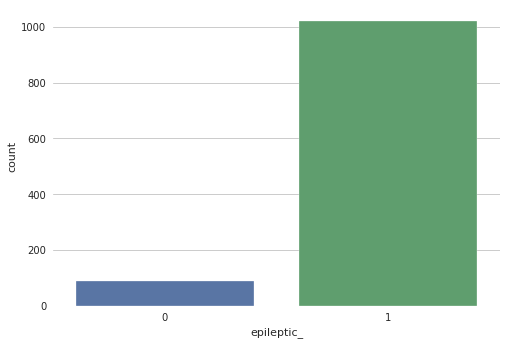

In [87]:
target = train['epileptic_']
train = train.drop(['epileptic_'], axis=1)
sns.set_style('whitegrid')
sns.countplot(target)

# **Distribution of Mean and Standard Deviation:=**

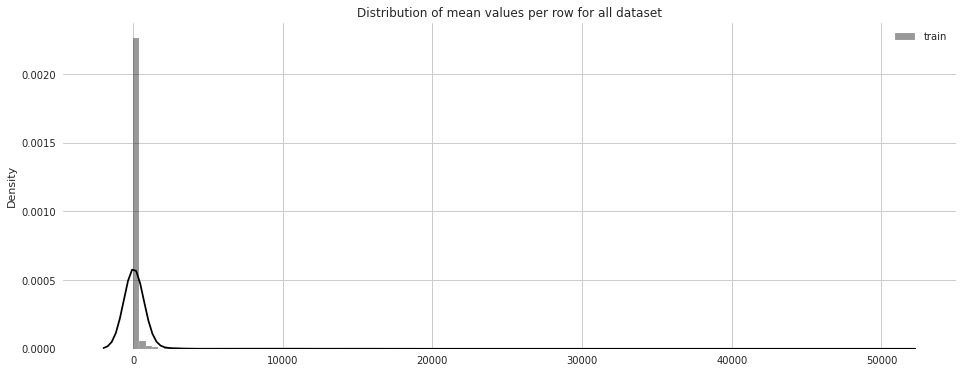

In [88]:
plt.figure(figsize=(16, 6))
plt.title('Distribution of mean values per row for all dataset')
sns.distplot(train.mean(axis=1), color='black',kde=True,bins=120, label='train')
plt.legend()
plt.show()

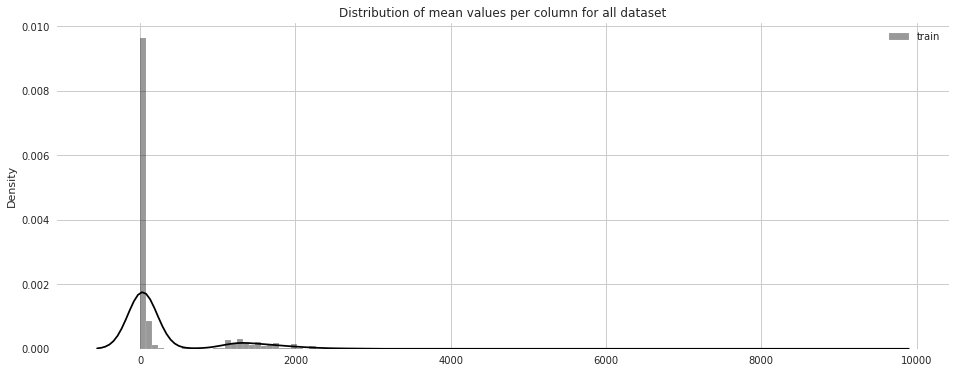

In [89]:
plt.figure(figsize=(16, 6))
plt.title('Distribution of mean values per column for all dataset')
sns.distplot(train.mean(axis=0), color='black',kde=True,bins=120, label='train')
plt.legend()
plt.show()

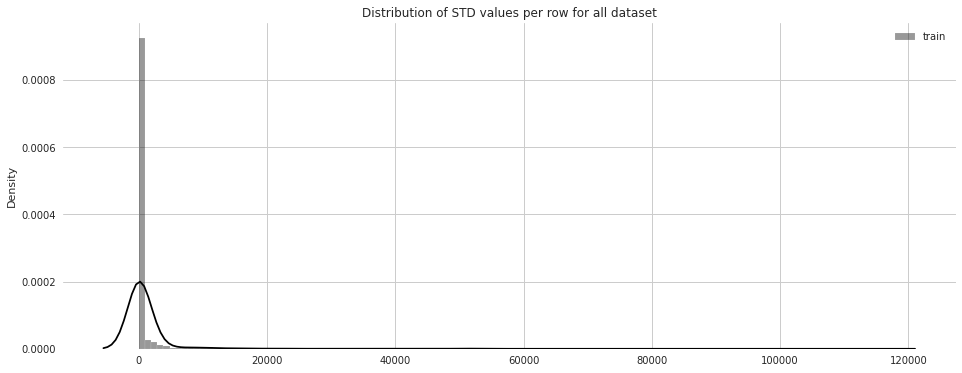

In [90]:
plt.figure(figsize=(16, 6))
plt.title('Distribution of STD values per row for all dataset')
sns.distplot(train.std(axis=1), color='black',kde=True,bins=120, label='train')
plt.legend()
plt.show()

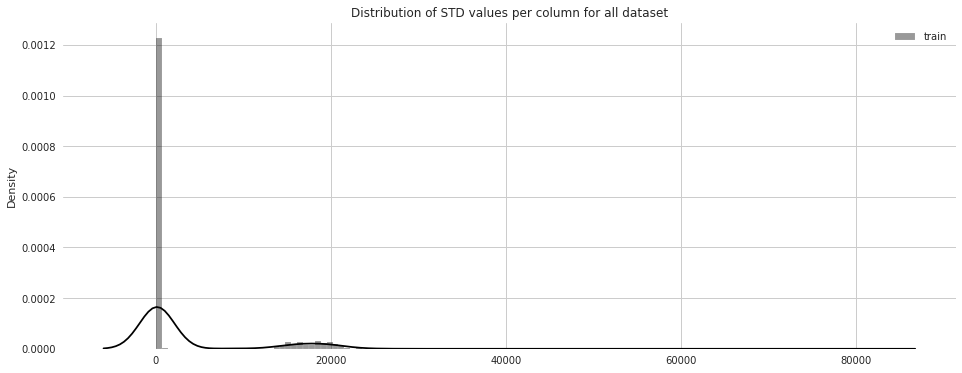

In [91]:
plt.figure(figsize=(16, 6))
plt.title('Distribution of STD values per column for all dataset')
sns.distplot(train.std(axis=0), color='black',kde=True,bins=120, label='train')
plt.legend()
plt.show()

# **Principal Component Analysis to check Dimentionality Reduction**

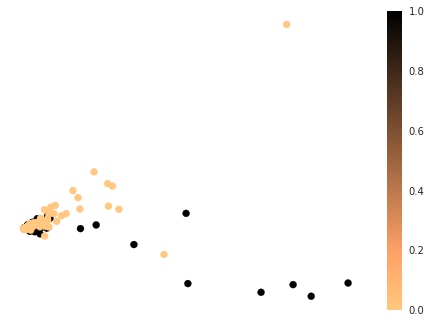

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
PCA_data = PCA(2).fit_transform(data_scaled)
plt.scatter(PCA_data[:,0], PCA_data[:,1], c=target, cmap='copper_r')
plt.axis('off')
plt.colorbar()
plt.show()

# **Creating Kernal PCA (Since the graph avove does not represent meaningful analysis)**

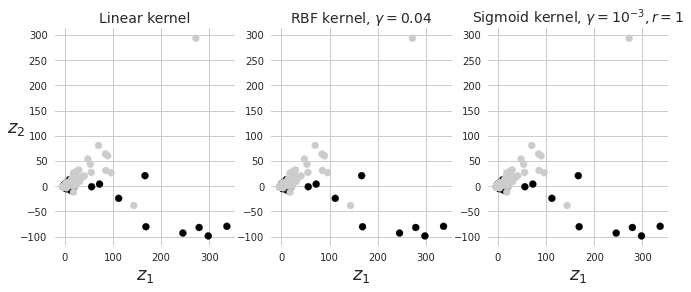

In [34]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_data = PCA(2).fit_transform(data_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_data[:, 0], PCA_data[:, 1], c=target, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()





# **Since PCA hasn't been useful, we decided to proceed with the existing dataset**

# **Data Augmentation**

In [35]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

# **Build Light GBM model:=**

In [36]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [96]:
num_folds = 11
features = [c for c in train.columns if c not in ['epileptic_']]

folds = KFold(n_splits=num_folds, random_state=0, shuffle=True)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
  




Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.991692	valid_1's auc: 0.879798
Early stopping, best iteration is:
[1219]	training's auc: 0.984221	valid_1's auc: 0.884848
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.991966	valid_1's auc: 0.905775
Early stopping, best iteration is:
[2389]	training's auc: 0.991835	valid_1's auc: 0.907295
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.992053	valid_1's auc: 0.740979
Early stopping, best iteration is:
[1561]	training's auc: 0.988164	valid_1's auc: 0.766753
Fold idx:4
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.991441	valid_1's auc: 0.858242
Early stopping, best iteration is:
[1813]	training's auc: 0.989314	valid_1's auc: 0.861538
Fold idx:5
Training until validation scores don't improve for 4000 rounds.
Early stopping, best 

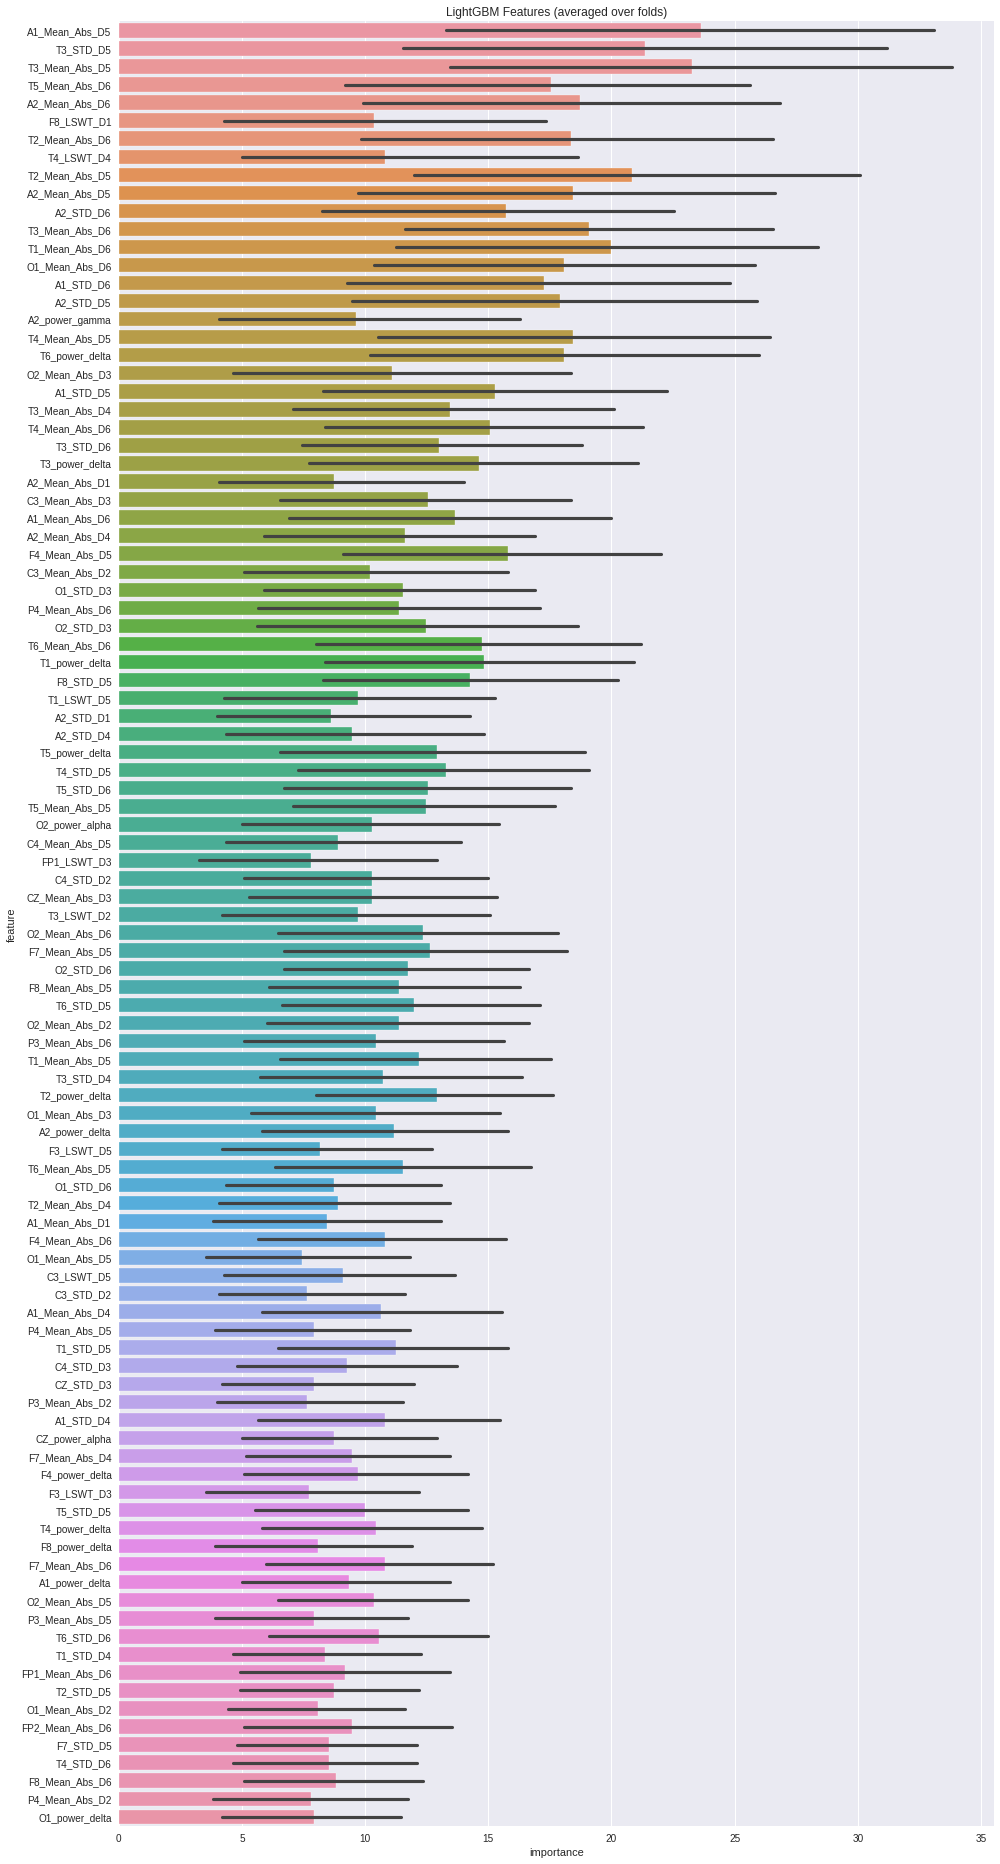

In [98]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
